In [26]:
import os
from copy import deepcopy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Normalize, Compose, Resize, CenterCrop, ToTensor
from torchvision import utils as torch_utils
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    # $pip install --quiet pytorch-lightning>=1.4
    import subprocess
    subprocess.check_call(["pip", "install", "--quiet", "pytorch-lightning>=1.4"])
    import pytorch_lightning as pl

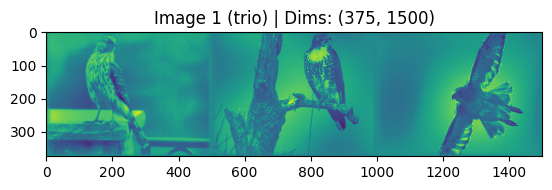

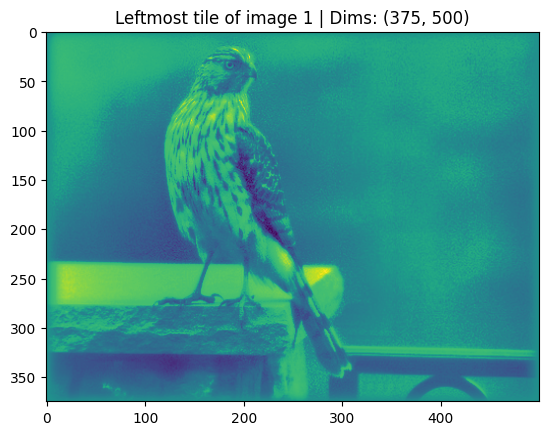

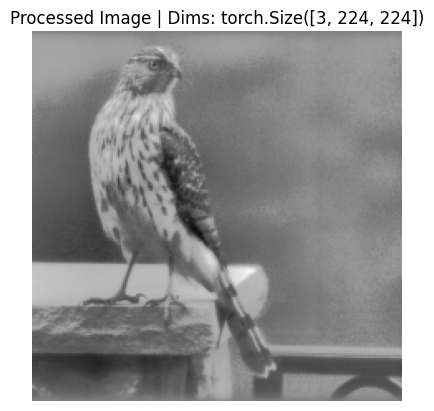

In [ ]:
### Load and check the image data

PATH_TO_DATA = '../../data/selection1866'

file_1 = loadmat(os.path.join(PATH_TO_DATA, 'img1.mat'))
raw_img_1 = file_1['img']

plt.imshow(raw_img_1)
plt.title("Image 1 (trio) | Dims: {}".format(raw_img_1.shape))
plt.show()

img_1_tile_1 = raw_img_1[:, :500]

plt.imshow(img_1_tile_1)
plt.title("Leftmost tile of image 1 | Dims: {}".format(img_1_tile_1.shape))
plt.show()

# Visualise the transformations we will apply
transform = Compose([
    Resize(224), # Resize shortest edge to 224
    CenterCrop((224, 224)), # Crop to (224, 224)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalize
])

rgb_img = np.stack([img_1_tile_1] * 3, axis=-1) # Convert to RGB
tensor = torch.tensor(rgb_img, dtype=torch.float32).permute(2, 0, 1) # Shape (C, H, W)
tensor = (tensor + 2) / 4.0  # Scale to [0, 1]
tensor = torch.clamp(tensor, 0.0, 1.0)  # Clamp to ensure [0, 1] range
processed_img = transform(tensor) # Resize, crop, normalize

plt.imshow((processed_img * 0.5 + 0.5).permute(1, 2, 0).clamp(0, 1).numpy())
plt.title("Processed Image | Dims: {}".format(processed_img.shape))
plt.axis('off')
plt.show()



Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Processed dataset shape: torch.Size([1866, 3, 224, 224])
Min pixel value (processed): -0.9998139142990112
Max pixel value (processed): 0.9999847412109375


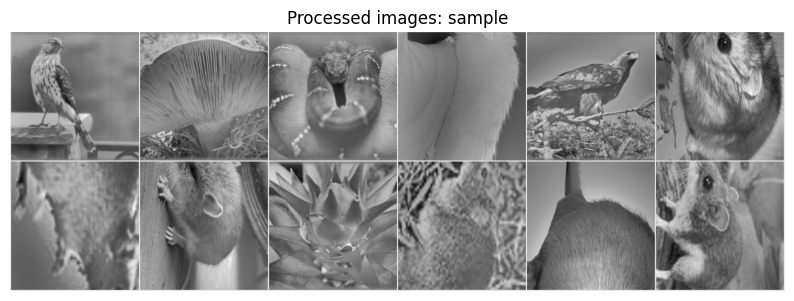

In [28]:
### Preprocess images for SimCLR

file_list = sorted(f for f in os.listdir(PATH_TO_DATA) if f.endswith('.mat'))

# Prepare images for SimCLR; todo: STL10 is 96x96
transform = Compose([
    Resize(224), # Resize shortest edge to 224 (cut off the rightmost part of the image)
    CenterCrop((224, 224)), # Crop to (224, 224)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # !! Normalize expects input is already in the range [0, 1]
])

img_tensors,labels = [], []
for idx, filename in enumerate(file_list):
    data = loadmat(os.path.join(PATH_TO_DATA, filename))
    
    img = data['img'][:, :500] # Take leftmost part of the image
    rgb_img = np.stack([img] * 3, axis=-1) # Convert grayscale to RGB for SimCLR
    
    tensor = torch.tensor(rgb_img, dtype=torch.float32).permute(2, 0, 1) # Shape (C, H, W)
    tensor = (tensor + 2) / 4.0  # Scale to [0, 1]
    tensor = torch.clamp(tensor, 0.0, 1.0)  # Clamp to ensure [0, 1] range
    transformed_tensor = transform(tensor) # Normalize and resize for SimCLR
    
    img_tensors.append(transformed_tensor)
    labels.append(idx)

dataset = TensorDataset(torch.stack(img_tensors), torch.tensor(labels))

images, labels = dataset.tensors
print("Labels:", labels[:10])
print("Processed dataset shape:", images.shape) # (N, C, 96, 96)
print(f"Min pixel value (processed): {torch.min(images)}")
print(f"Max pixel value (processed): {torch.max(images)}")

# Show a sample of processed images
img_grid = torch_utils.make_grid(images[:12], nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))
plt.title('Processed images: sample')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [29]:
### Extract feature representations of our images from a pretrained SimCLR model

MODEL_CHECKPOINT_PATH = "../../models/tutorial17/SimCLR.ckpt"

NUM_WORKERS = os.cpu_count()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc, # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

# Function to register hooks and capture outputs from intermediate layers
def register_hooks(model, layers):
    features = {}

    def hook(module, input, output, layer_name):
        features[layer_name] = output.detach()

    for layer_name in layers:
        layer = dict([*model.named_modules()])[layer_name]
        layer.register_forward_hook(lambda module, input, output, layer_name=layer_name: hook(module, input, output, layer_name))
    
    return features

# Run the pretrained SimCLR model on the experiment images, and capture features from final layer and intermediate layers
@torch.no_grad()
def extract_simclr_features(model, dataset, layers_to_capture):
    # Prepare model and register hooks
    network = deepcopy(model.convnet)
    network.fc = nn.Identity() # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Register hooks to capture specific intermediate layers
    features = register_hooks(network, layers_to_capture)
    
    # Encode all images
    data_loader = DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels, intermediate_features = [], [], {layer: [] for layer in layers_to_capture}
    
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
        
        # Collect intermediate layer outputs
        for layer in layers_to_capture:
            # Final linear layer outputs a 2d tensor; but intermediate layers don't, so we flatten them ready for PCA 
            layer_output_flattened = features[layer].view(features[layer].size(0), -1) 
            intermediate_features[layer].append(layer_output_flattened.cpu())
    
    # Concatenate results for each layer
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    intermediate_features = {layer: torch.cat(intermediate_features[layer], dim=0) for layer in layers_to_capture}
    
    return TensorDataset(feats, labels), intermediate_features

# Load the pretrained SimCLR model
model = SimCLR.load_from_checkpoint(MODEL_CHECKPOINT_PATH)
model.eval()

# Extract SimCLR representations and intermediate features
layers_to_capture = ['layer1', 'layer2', 'layer3', 'layer4']
final_layer, intermediate_features = extract_simclr_features(model, dataset, layers_to_capture)
final_layer_feats, labels = final_layer.tensors
layer1_feats = intermediate_features['layer1']
layer2_feats = intermediate_features['layer2']
layer4_feats = intermediate_features['layer4']

Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../models/tutorial17/SimCLR.ckpt`


Device: cpu
Number of workers: 10


  0%|          | 0/30 [00:00<?, ?it/s]

First 10 labels in SimCLR features: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


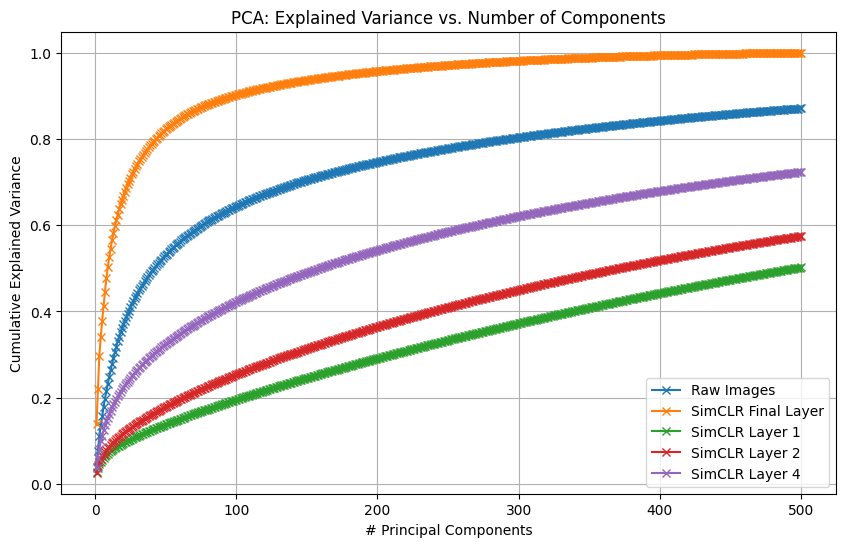

In [30]:
### PCA

num_components = 500

def cumulative_ev(data, num_components=num_components, flatten_data=False):
    data = data.view(data.size(0), -1) if flatten_data else data

    pca = PCA(n_components=num_components)
    pca.fit(data)
    explained_variance = pca.explained_variance_ratio_
    return np.cumsum(explained_variance)

print("First 10 labels in SimCLR features:", labels[:10])

# Plot cumulative explained var vs. # principal components
plot_components = range(1, num_components + 1)
plt.figure(figsize=(10, 6))
plt.plot(plot_components, cumulative_ev(images, flatten_data=True), label="Raw Images", marker='x')
plt.plot(plot_components, cumulative_ev(final_layer_feats.numpy()), label="SimCLR Final Layer", marker='x')
plt.plot(plot_components, cumulative_ev(layer1_feats), label="SimCLR Layer 1", marker='x')
plt.plot(plot_components, cumulative_ev(layer2_feats), label="SimCLR Layer 2", marker='x')
plt.plot(plot_components, cumulative_ev(layer4_feats), label="SimCLR Layer 4", marker='x')

plt.xlabel("# Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.legend()
plt.grid(True)
plt.show()

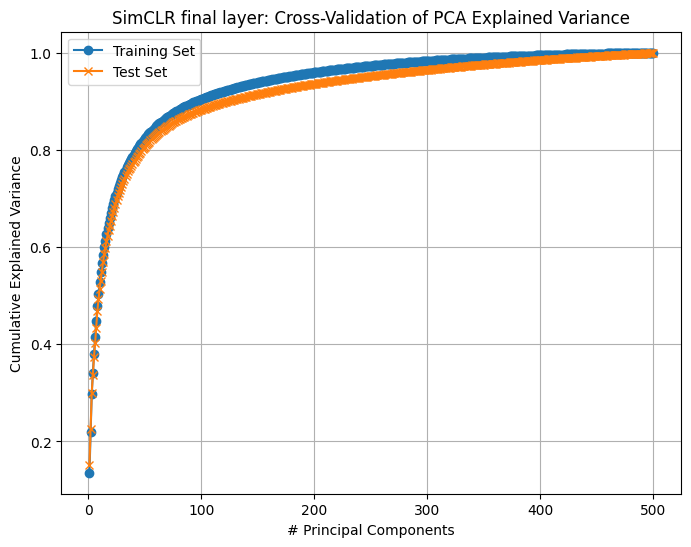

In [31]:
### Cross validate PCA results for SimCLR final layer

# Run PCA on "training" subset of the representations
simclr_train, simclr_test = torch.utils.data.random_split(final_layer_feats, [1508, 358])
pca_simclr = PCA(n_components=num_components)
pca_simclr.fit(simclr_train)
explained_var_simclr_train = pca_simclr.explained_variance_ratio_

# Fit the PCA model on the test set 
simclr_test_transformed = pca_simclr.transform(simclr_test)
explained_var_simclr_test = np.var(simclr_test_transformed, axis=0) / np.sum(np.var(simclr_test, axis=0))

# Compute cumulative explained variances
cumulative_variance_train = np.cumsum(explained_var_simclr_train)
cumulative_variance_test = np.cumsum(explained_var_simclr_test)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_train) + 1), cumulative_variance_train, label="Training Set", marker='o')
plt.plot(range(1, len(cumulative_variance_test) + 1), cumulative_variance_test, label="Test Set", marker='x')
plt.xlabel("# Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("SimCLR final layer: Cross-Validation of PCA Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

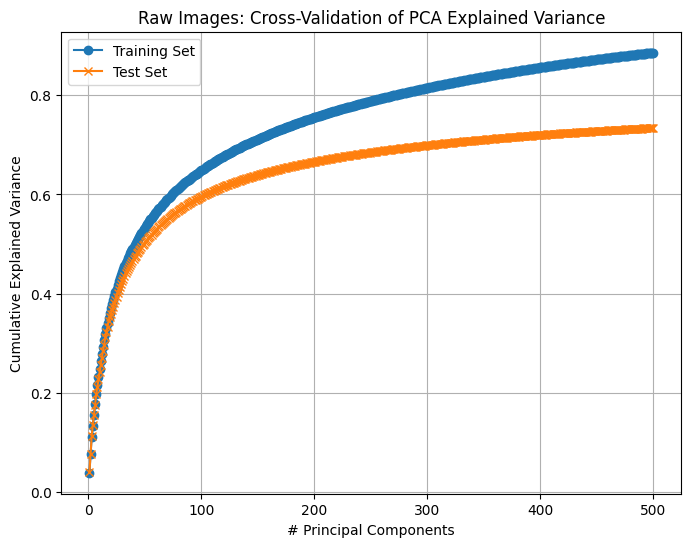

In [32]:
### Cross validate PCA results for raw image data

# Run PCA on "training" subset of the representations
flattened_images = images.view(images.size(0), -1)
raw_images_train, raw_images_test = torch.utils.data.random_split(flattened_images, [1508, 358])
pca_raw_images = PCA(n_components=num_components)
pca_raw_images.fit(raw_images_train)
explained_var_raw_images_train = pca_raw_images.explained_variance_ratio_

# Fit the PCA model on the test set 
raw_images_test_transformed = pca_raw_images.transform(raw_images_test)
explained_var_raw_images_test = np.var(raw_images_test_transformed, axis=0) / np.sum(np.var(raw_images_test, axis=0))

# Compute cumulative explained variances
cumulative_variance_train = np.cumsum(explained_var_raw_images_train)
cumulative_variance_test = np.cumsum(explained_var_raw_images_test)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_train) + 1), cumulative_variance_train, label="Training Set", marker='o')
plt.plot(range(1, len(cumulative_variance_test) + 1), cumulative_variance_test, label="Test Set", marker='x')
plt.xlabel("# Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Raw Images: Cross-Validation of PCA Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92630893..0.9742806].


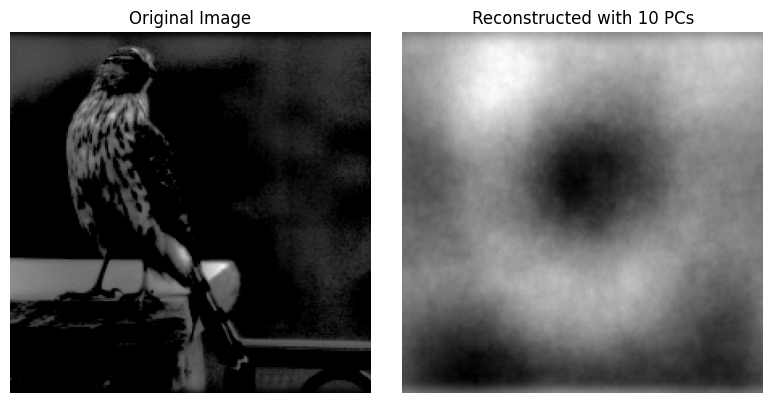

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to project an image into PCA space and reconstruct it back
def pca_image_projection(image, pca, num_components, original_shape):
    """
    Project an image into PCA space and reconstruct it back into pixel space.

    Args:
        image: The original image as a flattened vector (1D array).
        pca: The fitted PCA object.
        num_components: Number of PCA components to use for reconstruction.
        original_shape: Tuple of the original shape (C, H, W).

    Returns:
        Reconstructed image in the original shape (C, H, W).
    """
    # Step 1: Project the image into PCA space
    image_pca = pca.transform(image.reshape(1, -1))  # Transform to PCA space
    image_pca[:, num_components:] = 0  # Keep only the top `num_components`

    # Step 2: Reconstruct the image back into pixel space
    reconstructed_image = pca.inverse_transform(image_pca)

    # Step 3: Reshape the reconstructed image to its original shape
    return reconstructed_image.reshape(original_shape)


# Step 1: Flatten the dataset
flattened_images = images.view(images.shape[0], -1)  # Shape: [1866, 150528]

# Step 2: Fit PCA on the flattened dataset
pca = PCA(n_components=100)  # Keep top 100 components
pca.fit(flattened_images.numpy())  # Convert to NumPy for PCA

# Step 3: Select an example image for projection
example_image = images[0].view(-1).numpy()  # Flatten the first image
original_shape = (3, 224, 224)  # Original shape of the image

# Step 4: Reconstruct the image using PCA
num_components = 10  # Adjust this to see the effect of different numbers of components
reconstructed_image = pca_image_projection(example_image, pca, num_components, original_shape)
reconstructed_image = (reconstructed_image - reconstructed_image.min()) / (reconstructed_image.max() - reconstructed_image.min())

# Step 5: Visualize the original and reconstructed images
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0).numpy())  # Convert to (H, W, C) for display
plt.title("Original Image")
plt.axis("off")

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.transpose(1, 2, 0))  # Convert to (H, W, C) for display
plt.title(f"Reconstructed with {num_components} PCs")
plt.axis("off")

plt.tight_layout()
plt.show()